In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Density Estimation via Gaussian mixtures

The density estimation problem is the following: you are given a set of observations $\mathbf{x}_1,\ldots,\mathbf{x}_n$ and you want to learn a model $p(\mathbf{x})$ that allows you to generate examples similar to your observations.
The Gaussian mixture model is a popular model for density estimation.
The model has the form:

$$
p(\mathbf{x}) = \sum_{k=1}^K\pi_kN(\mathbf{x}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k),
$$

where $\pi_k, \boldsymbol{\mu}_k$, and $\boldsymbol{\Sigma}_k$ are parameters to be estimated from the data.
The Gaussian mixture model assumes that there are $K$ possible sources that may generate the data and that each one is a multivariate Gaussian with parameters to be estimated.
Solving the density estimation problem using mixtures of Gaussian essentially also solves the clustering problem because you can think of the $K$ different Gaussians as defining the clusters.
If you want to study Gaussian mixtures independently, I suggest reading [Chapter 9, Bishop (2006)](https://www.springer.com/gp/book/9780387310732) (You should have free online access to the book through Purdue).

We train a Gaussian mixture model by maximizing the log-likelihood of the data.
The log-likelihood is given by:

$$
\log p(\mathbf{X}|\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma}) = \sum_{i=1}^n\log\left\{\sum_{k=1}^K\pi_kN(\mathbf{x}_i|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)\right\},
$$

where $\boldsymbol{\pi} = (\pi_1,\ldots,\pi_K)$, $\boldsymbol{\mu} = (\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_K)$, and $\boldsymbol{\Sigma} = (\boldsymbol{\Sigma}_1,\ldots,\boldsymbol{\Sigma}_K)$.

The algorithm used to maximize the log-likelihood is the [expectation-maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) or EM.
The EM algorithm is an iterative algorithm that alternates between an expectation step (E-step) and a maximization step (M-step).
The E-step computes the expected value of the log-likelihood with respect to the conditional distribution of the latent variables given the observed data and the current estimate of the parameters.
The latent variables here are the cluster assignments.
The M-step maximizes the expected value of the log-likelihood with respect to the parameters.
More details on the reference above.

## Avoiding overfitting using the Bayesian information criterion

If you pick a model with too many parameters, you may overfit. If you choose a model with too few parameters, you may underfit.
In the Gaussian mixtures example above, you get to choose $K$.
You can choose $K$ to be one, and then you are essentially saying that a single cluster can be described with a multivariate Gaussian.
This may be inadequate, and you are going to underfit the data.
On the other extreme, you may pick $K$ to be $n$, i.e., the number of observations you have.
In this case, you would fit a different Gaussian on each observed point.
This is, of course, ridiculous. You are going to overfit.

So, how do you pick the correct number of mixture components $K$?
The formal answer is that you should be Bayesian all the way.
Put a prior probability on $K$, then characterize the posterior over $K$.
This is doable; it is known as Bayesian model selection (see [Chapter 1.3, Bishop (2006)](https://www.springer.com/gp/book/9780387310732), but we are not yet equipped to carry it out.
However, there is an approximation to Bayesian model selection that is very straightforward to carry out: the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) or BIC.
The details are presented in the video lecture, but if you want to study this independently, the Wikipedia article on [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) is well written, and you may also want to take a look at [Chapter 4.4.1, Bishop (2006)](https://www.springer.com/gp/book/9780387310732).

The BIC is given by:

$$
\mathrm{BIC} = -2\log \text{likelihood} + \text{number of parameters}\times\log n.
$$

The smaller the BIC, the better the model.

## Example

We are going to demonstrate the concepts using a synthetic example.
Let's generate the synthetic data:

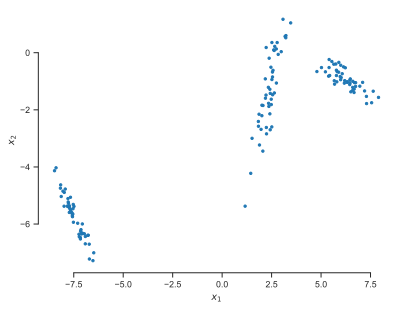

In [13]:
np.random.seed(123456)

# Make synthetic dataset for clustering
num_clusters_true = 3
# The means of each cluster
mu_true = 5.0 * np.random.randn(num_clusters_true, 2)
# The variance of the observations around the cluster
# Covariance of each cluster
Sigmas = []
for i in range(num_clusters_true):
    u = 0.5 * np.random.randn(2, 1)
    v = 0.5 * np.random.randn(2, 1)
    Sigma = np.dot(u, u.T) + np.dot(v, v.T)
    Sigmas.append(Sigma)
# How many observations to generate per cluster
num_obs_cluster = [50, 50, 50]

# Generate the data
data = []
for i in range(num_clusters_true):
    x_i = np.random.multivariate_normal(mu_true[i], Sigmas[i], 
                                        size=num_obs_cluster[i])
    data.append(x_i)
data = np.vstack(data)

# Permute the data so that order info is lost
data = np.random.permutation(data)

# Visualize
fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1], '.')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

We will use the [sciki-learn implementation](https://scikit-learn.org/stable/modules/mixture.html) of Gaussian mixtures.
Here is how you can set up a model and fit it:

In [14]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3).fit(data)

Note that we picked three components for the mixture (which happens to be the true number of mixtures).
Here are the three mean vectors identified by the model:

In [15]:
model.means_

array([[ 2.40053388, -1.3058076 ],
       [-7.46929254, -5.73926691],
       [ 6.23874412, -0.93769159]])

Compare these to the true mean vectors:

In [16]:
mu_true

array([[ 2.3455615 , -1.41431672],
       [-7.54529252, -5.67816186],
       [ 6.06056013, -0.86607325]])

The model identifies one covariance matrix per mixture component.
These are stored in a 3D array (first dimension = mixture component).
Here is how to access it:

In [17]:
model.covariances_

array([[[ 0.20382394,  0.53776024],
        [ 0.53776024,  1.94763635]],

       [[ 0.22431117, -0.33125352],
        [-0.33125352,  0.53270818]],

       [[ 0.46188069, -0.1988742 ],
        [-0.1988742 ,  0.13489411]]])

Remember that the Gaussian mixture model is fitting the joint probability density function of the data, say $p(\mathbf{x})$.
In 2D, you can plot the contours of this probability density function.
We will plot the contours of the logarithm of the probability function, i.e., the contours of $\log p(\mathbf{x})$.
Here is how to do it.

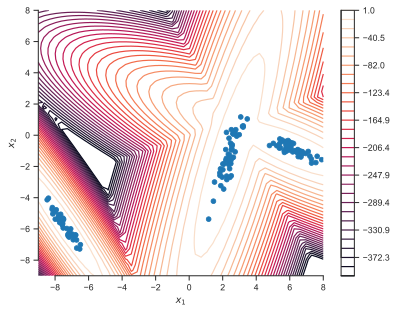

In [18]:
# Make grid
x = np.linspace(-9., 8.)
y = np.linspace(-9., 8.)
X, Y = np.meshgrid(x, y)

# Get PDF on grid points
XX = np.array([X.ravel(), Y.ravel()]).T
z = model.score_samples(XX)
Z = z.reshape(X.shape)

# Plot
fig, ax = plt.subplots()
c = ax.contour(
    X,
    Y,
    Z,
    levels=np.linspace(-400, 1.0, 30)
)
plt.colorbar(c)
plt.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

You can also use the Gaussian mixture model to cluster the data.
Clustering is performed as follows.
For each point $\mathbf{x}$ that you would like to cluster:
- calculate the probability $p_k$ that the point belongs to the $k$-th mixture component, i.e., calculate:

$$
p_k = \frac{\pi_kN(\mathbf{x}|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}{\sum_{k'=1}^K\pi_{k'}N(\mathbf{x}|\boldsymbol{\mu}_{k'},\boldsymbol{\Sigma}_{k'})}.
$$

- assign the point to the cluster $k^*$ with the highest probability, i.e.,

$$
k^* = \arg\max_{k}p_k.
$$

Scikit-learn already implements this functionality.
Here is how to do it:

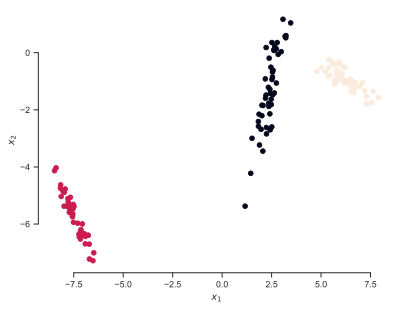

In [19]:
labels = model.predict(data)

fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1], c=labels)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

Another helpful thing you can do is sample from the estimated probability density.
This can be implemented through the following procedure:
+ sample a mixture component $k$ in $1,\dots,K$, with probability $\pi_k$, i.e., sample from the Categorical random variable $\operatorname{Categorical}(\pi_1,\dots,\pi_K)$.
+ then sample an $\mathbf{x}$ from the Gaussian $N(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)$.
Again, scikit-learn implements this for you.
Here is how to access it:

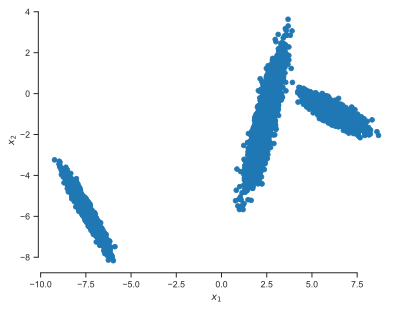

In [10]:
s_data, labels = model.sample(10000)

fig, ax = plt.subplots()
ax.scatter(s_data[:, 0], s_data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

Alright! Everything works as expected when we use just the correct number of components.
Let's see what happens when we use a different number of components.
We are going to start with fewer components than the correct number.
Let's try two components.

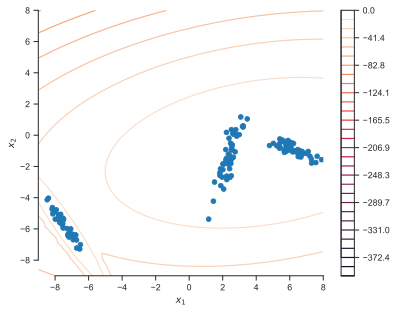

In [20]:
# Fit
model = GaussianMixture(n_components=2).fit(data)

# Plot contour of PDF
Z = model.score_samples(XX)
Z = Z.reshape(X.shape)
fig, ax = plt.subplots()
c = ax.contour(
    X,
    Y,
    Z,
    levels=np.linspace(-400, 0.0, 30)
)
plt.colorbar(c)
plt.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

Observe that the model is grouping two of the components together.
It puts them in the same Gaussian.
That's the best it can do with two components.
This is clearly underfitting.

Let's now try more components than the right number.
We are going to do 5.
Here we go:

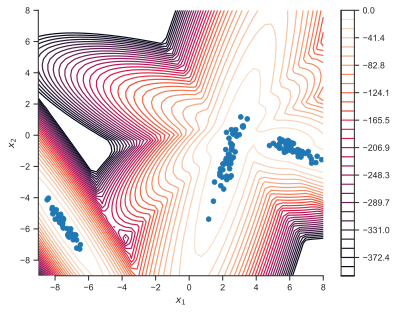

In [21]:
# Fit
model = GaussianMixture(n_components=5).fit(data)

# Plot contour of PDF
Z = model.score_samples(XX)
Z = Z.reshape(X.shape)
fig, ax = plt.subplots()
c = ax.contour(
    X,
    Y,
    Z,
    levels=np.linspace(-400, 0.0, 30)
)
plt.colorbar(c)
plt.scatter(data[:, 0], data[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

The density doesn't look very bad even though we used more components.
(The density will start looking bad if you use more components).
How does the clustering look like when we use five componets?
Let's see:

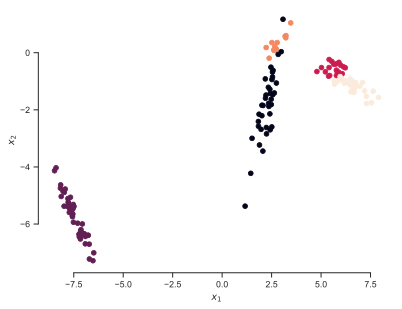

In [22]:
labels = model.predict(data)

fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1], c=labels)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

Okay. The model found five clusters (because we asked for them), but we can visually see in this example that it is overfitting.

Let's now apply the Bayesian information criterion (BIC) to select the number of clusters.
First, we loop over all models with 1 to 10 components, and we calculate the BIC for each one of them:

In [23]:
max_num_components=10

bics = np.ndarray((max_num_components - 1,))
models = []

for nc in range(1, max_num_components):
    m = GaussianMixture(n_components=nc).fit(data)
    bics[nc - 1] = m.bic(data)
    models.append(m)

Now let's visualize the BICS:

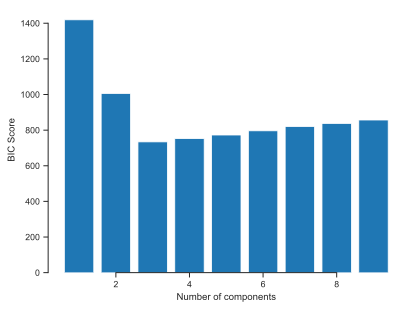

In [24]:
fig, ax = plt.subplots()
ax.bar(range(1, max_num_components), bics)
ax.set_ylabel('BIC Score')
ax.set_xlabel('Number of components')
sns.despine(trim=True);

Remember that the model with the smallest BIC is the best.
The procedure selects three components for this synthetic dataset, which is the correct number.

## Questions

+ Change the random seed a couple of times (to whatever integer you want) and generate more examples.

+ Change the number of true components in the synthetic dataset to 5 and repeat. Does BIC work?